<a href="https://colab.research.google.com/github/kike22-22/IA/blob/main/Pr%C3%A1ctica_1_Clasificador_de_Ropa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

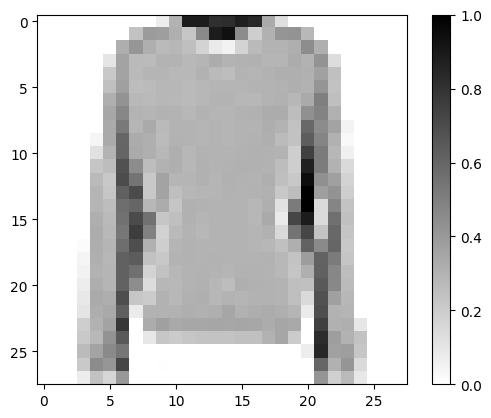

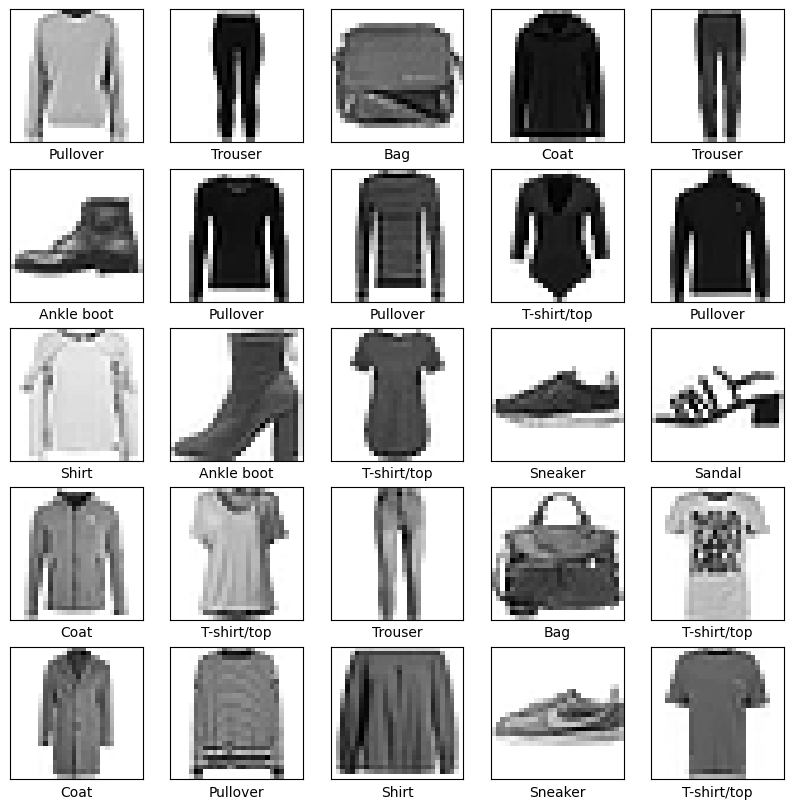

60000
10000
Epoch 1/5
1875/1875 [==============================] - 12s 3ms/step - loss: 0.5163 - accuracy: 0.8162
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3760 - accuracy: 0.8645
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3494 - accuracy: 0.8721
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3253 - accuracy: 0.8806
Epoch 5/5
1/1 [==============================] - 0s 83ms/step
prediccion:T-shirt/top
mkdir: cannot create directory ‘clasificacion’: File exists
2024-11-11 04:23:22.465164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731299002.505871    6246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731299002.517927    6246 cuda_blas.cc:14

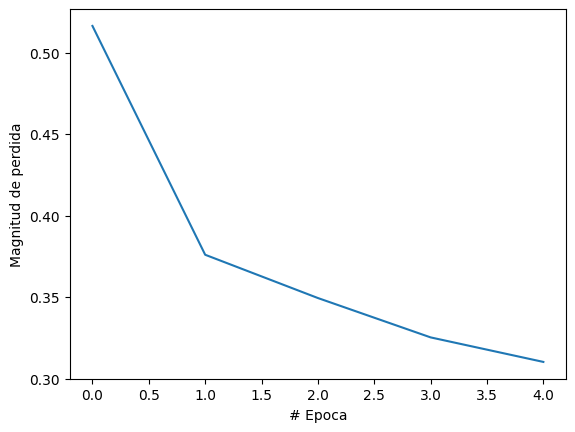

In [23]:
#instalar python 3.8
!sudo apt-get update -y
!sudo apt-get install python3.8 python3.8-dev python3.8-venv -y
# crear un entorno virtual con python
!python3.8 -m venv tfjs-venv
# activar el entorno virtual
!source tfjs-venv/bin/activate
#paso 2
!tfjs-venv/bin/pip install --upgrade pip
!tfjs-venv/bin/pip install tensorflow==2.8 tensorflowjs_converter

!pip install tensorflow-decision-forests --upgrade

!pip install tensorflowjs
!pip install tensorflow-decision-forests --upgrade
#paso 3
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
#paso 4
import tensorflow as tf
import tensorflow_datasets as tfds
# paso 5 Descargar set de datos de fashion MNIST de zalando
datos,metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
#paso 6
metadatos
#paso 7 obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']
#paso 8  etiquetas de las 10 categorias posibles
nombres_clases = metadatos.features['label'].names
nombres_clases
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar lso datos de entrenamiento
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#agregar a cache
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28))

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()
#Dibujar mas
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
#compilar modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)
TAMANO_LOTE = 32
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)
import math
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])
import numpy as np
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_pruebas = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_pruebas)

def graficar_imagen(i,arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = "blue"
  else:
    color = "red"

##--------------------------------------------------------------

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                       100*np.max(arr_predicciones),
                                       nombres_clases[etiqueta_real]),
                                       color=color)

  def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
    arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica = plt.bar(range(10), arr_predicciones, color="#777777")
    plt.ylim([0,1])
    etiqueta_prediccion = np.argmax(arr_predicciones)

##--------------------------------------------------------------

    grafica[etiqueta_prediccion].set_color("red")
    grafica[etiqueta_real].set_color("blue")


    filas =5
    columnas = 3
    num_imagenes = filas*columnas
    plt.figure(figsize=(2*2*columnas, 2*filas))
    for i in range(num_imagenes):
      plt.subplot(filas, 2*columnas, 2*i+1)
      graficar_imagen(i, predicciones, etiquetas_prueba,imagenes_prueb)
      plt.subplot(filas, 2*columnas, 2*i+2)
      graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
      imagen = imagenes_pruebas[4]
imagen = np.array([imagen])
predicciones_single = modelo.predict(imagen)

print("prediccion:"+ nombres_clases[np.argmax(predicciones_single[0])])
!mkdir clasificacion

modelo.save('clasificacion.h5')

!tensorflowjs_converter --input_format keras clasificacion.h5 clasificacion
